# Movie Lens Recommendation Systems

**Authors:**  Tony Bai, Eddie Lin, Douglas Lu, Shane Mangold
***

## Overview

In this project we will aim to explore different types of Recommendation Systems by utilizing the classic MovieLens 100K dataset.

## Business Problem
![image.png](./images/title_image.png)

Every Recommendation System these days, whether its Hulu, Netflix or Prime Video, are limited only to those movies that 
are available on each application's network. In order to circumnavigate this challenge, we aim to build a third party movie recommender program that can take a title and recommend users similar movies that are not limited to a specific streaming platform.

## Data Understanding

The data for this project comes from the well-known MovieLens 100k dataset. The data represent user reviews for a given movie as well as different movie genres tied to each movie. Though many variables are included, for our purposes in building recommendation systems, the target variable in this case is somewhat ambiguous. Furthermore, while some of our models will predict a given user rating based on other inputs, other models will recommend movies based on inputs but suffer from the lack of ground-truth comparisons. Thus, in this case, we must change our evaluation metrics to ensure that our models can be evaluated appropriately.

### Summary Data:

>The Movies CSV files contains 9742 movies containing the movieID, title, and genre. There are no null values in this dataset.

>The Ratings CSV file contains 100836 files which is more than the movies CSV file. There are also no null values in this dataset.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVDpp, accuracy
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import linear_kernel
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [2]:
#load dataset
movies = pd.read_csv('Data/movies.csv')
ratings = pd.read_csv('Data/ratings.csv')              

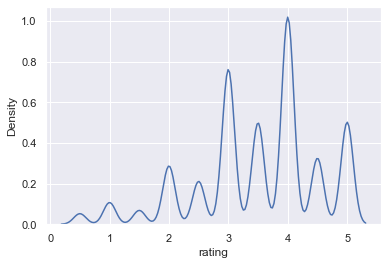

In [3]:
#exploratory data
sns.set_style('whitegrid')
sns.set(font_scale = 1)
sns.kdeplot(ratings['rating'].fillna(ratings['rating'].median()));

As you can see most movies are rated highly >3 in this dataset, perhaps revealing the fact that most users are generous with their ratings.

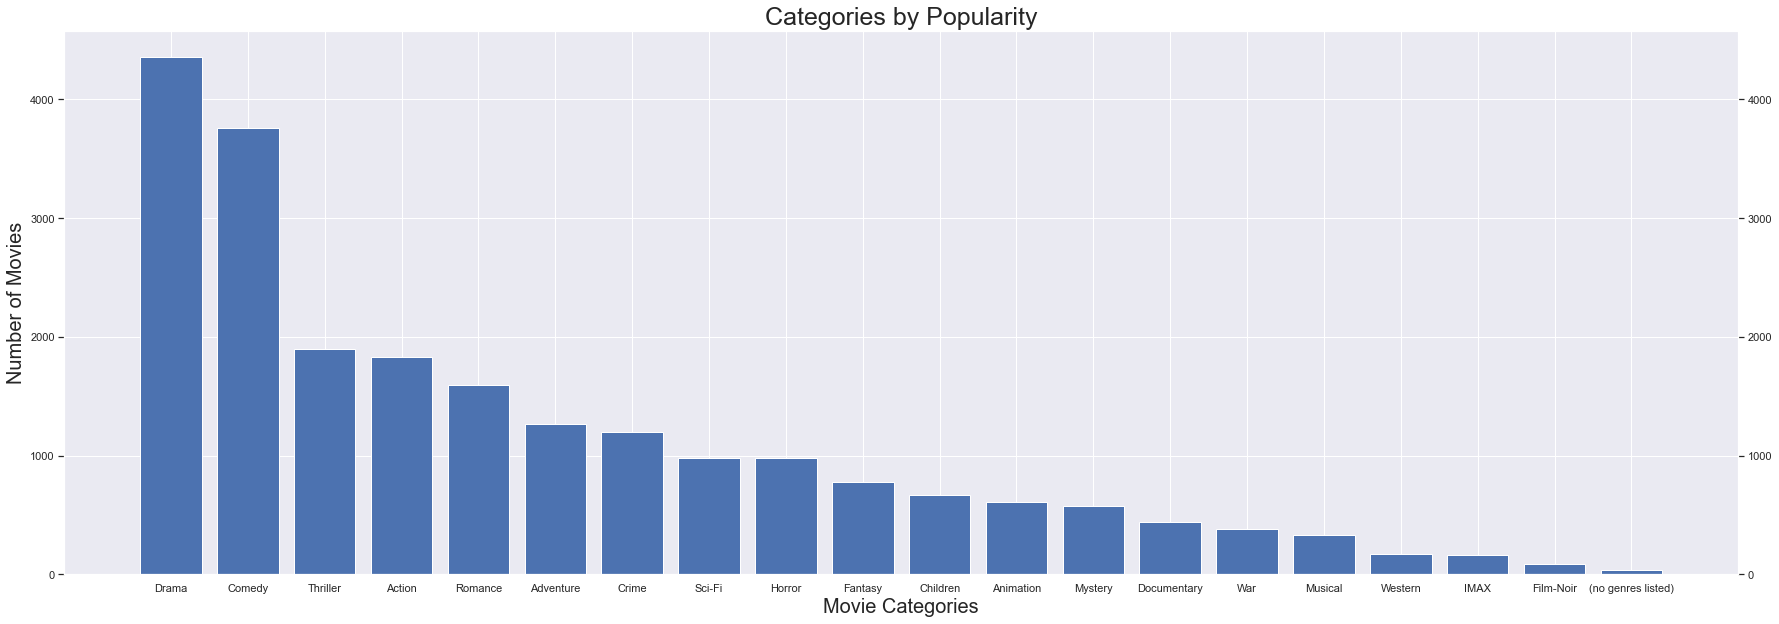

In [4]:
movie_df2 = movies.copy()
movie_df2['genres'] = movie_df2['genres'].str.strip().str.split('|')
genres_df = movie_df2.explode('genres')

#initiate graph 
fig, ax = plt.subplots(figsize = (30,10))


#set the x and y parameters
x = genres_df.groupby('genres')['movieId'].count().sort_values(ascending = False).index
height = genres_df.groupby('genres')['movieId'].count().sort_values(ascending = False)

#set axes labels
ax.set_xlabel('Movie Categories',size = 20)
ax.set_ylabel('Number of Movies',size = 20)
ax.set_title('Categories by Popularity',size = 25)

#display y-yabel and ticks on both left and right side
plt.tick_params(labelright = True)
ax.yaxis.set_ticks_position('both')

#set the tick sizes for graph
plt.yticks(size = 11)
plt.xticks(rotation = 0, size = 11)

#plot the bar graph of categories vs movies
ax.bar(x,height);

The entire dataset is around 100,000 movies, and you can see that the top few movie genres make up for the majority of the data. This could pose a problem later on if we were to make recommendations based on genre.

## Data Preparation

For our analysis we dropped timeseries information and only use the movies.csv and ratings.csv files. Given the nature of the filtering models we cretaed, much of the data was not necessary to address the business problem.

Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
df_joined = pd.merge(ratings, movies)
df_joined.drop(['userId', 'timestamp','rating'], axis=1)
df_joined.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## Data Modeling


## SVD with Surprise

We decided to implenment Surprise's packages and use it as a first model due to its built in tools and ease of use.

In [10]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['movieId', 'userId', 'rating']], reader)
dataset = data.build_full_trainset()

In [11]:
#need to add more to the grid search later
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8735367078845842, 'mae': 0.6724409642549837}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'reg_all': 0.05}}


## KNearest Neighbors

We then used a KNN model to generate predictions for our movies. Since a recommendation system using KNN would just result in obtaining the movies with the highest predicted score, we decided to look into collaborative filtering as a modeling technique in order to achieve more personalization for our users' movie recommendations. 

In [12]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [13]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.88884318, 0.89375376, 0.88218068, 0.87874135, 0.88680554]))
('test_mae', array([0.68356037, 0.68616848, 0.67852276, 0.67741362, 0.68199016]))
('fit_time', (29.039143562316895, 29.121608018875122, 29.44596552848816, 33.97300314903259, 30.480137586593628))
('test_time', (11.217522144317627, 11.384176015853882, 16.018832445144653, 12.923232555389404, 11.55880355834961))


0.8860649024412236

In [14]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.3676199939791367, details={'was_impossible': False})

In [15]:
#created a function that uses your ratings/input to forecast and recommend other movies
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list      

In [16]:
user_rating = movie_rater(df_joined, 3, 'Action')

       userId  movieId  rating  timestamp  \
51981      19     1374     5.0  965709478   

                                        title  \
51981  Star Trek II: The Wrath of Khan (1982)   

                                 genres  
51981  Action|Adventure|Sci-Fi|Thriller  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
1
       userId  movieId  rating   timestamp                title  \
81128     318    82461     3.5  1324062199  Tron: Legacy (2010)   

                             genres  
81128  Action|Adventure|Sci-Fi|IMAX  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
1
       userId  movieId  rating   timestamp             title        genres
71888     452     3107     4.0  1019580751  Backdraft (1991)  Action|Drama
How do you rate this movie on a scale of 1-5, press n if you have not seen :
1


In [17]:
#obtain the user inputed ratings
user_rating

[{'userId': 1000, 'movieId': 1374, 'rating': '1'},
 {'userId': 1000, 'movieId': 82461, 'rating': '1'},
 {'userId': 1000, 'movieId': 3107, 'rating': '1'}]

In [18]:
df_joined

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [19]:
#merging the new inputed data onto the main dataframe
df_new = df_joined.drop(['genres','title','timestamp'], axis=1)
new_ratings = df_new.append(user_rating,ignore_index=True)

#convert this into a Suprise dataset
new_data = Dataset.load_from_df(new_ratings,reader)

In [20]:
#using Suprises SVD with grid searched params
svd_ = SVD(n_factors= 50, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())

In [21]:
#evaluate the model

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()
svd_.fit(trainset)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8590  0.8700  0.8700  0.8708  0.8776  0.8695  0.0060  
MAE (testset)     0.6630  0.6692  0.6674  0.6706  0.6731  0.6686  0.0034  
Fit time          4.03    3.77    3.81    4.83    4.54    4.20    0.42    
Test time         0.26    0.15    0.23    0.30    0.24    0.23    0.05    


{'test_rmse': array([0.85896147, 0.87001453, 0.87002852, 0.8707797 , 0.87759669]),
 'test_mae': array([0.66297192, 0.66915361, 0.66736484, 0.67058791, 0.67310262]),
 'fit_time': (4.029832363128662,
  3.7684266567230225,
  3.808523178100586,
  4.827126979827881,
  4.5438055992126465),
 'test_time': (0.2583472728729248,
  0.15055084228515625,
  0.22945618629455566,
  0.2989332675933838,
  0.23620200157165527)}

In [22]:
#appending everything into a list
#here we are specifically predicting how user (user 32) would rate every single movie in the dataset
list_of_movies = []
for m_id in df_new['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(32,m_id)[3]))

In [23]:
# as you can see this list is the entire dataset
len(list_of_movies)

9724

In [24]:
#returns the first 5 movies in the list
list_of_movies[:5]

[(1, 4.027708732432148),
 (3, 3.409410537936326),
 (6, 4.0885130608160205),
 (47, 4.079396902232134),
 (50, 4.354952859763857)]

In [25]:
#sort the list from highest predicted scores
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [26]:
ranked_movies[:5]

[(1204, 4.525498901595377),
 (750, 4.521912934829535),
 (318, 4.5029505891546675),
 (7361, 4.465990960815359),
 (898, 4.463527724039234)]

In [27]:
#function to turn our recommendations into movie titles
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,4)

Recommendation #  1 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  2 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  3 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  4 :  4909    Eternal Sunshine of the Spotless Mind (2004)
Name: title, dtype: object 



## Content-Based Filtering

![image.png](./images/collaborative_filtering.png)
Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. Here we chose to measure similarity with **Cosine Similarity** (in short it measures the angles between non zero vectors). The score is on a scale of 0-1. A score of 0 means that the two vectors are orthogonal and have no match while a score of 1 means that they are identical.

>Below we use a TFIDF vectorizer and linear kernel to compute the pairwise distances

In [28]:
#define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

In [29]:
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies['genres'])

#linear kernel is same thing according to the documentation
cosine_score = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)

In [30]:
#using TF-IDF Vectorizer Object to calculate recommendations
def get_recommendations_based_on_genres(movie_title, cosine_score=cosine_score):
    """
     Calculates top movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    #Get the index of the movie that matches the title
    index_mov = movies.loc[movies['title'].isin([movie_title])]
    index_mov = index_mov.index
    
    #Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_score[index_mov][0]))
    
    #Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    #Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[0:10]
    
    
    #Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies if i[0] not in index_mov]
    
    #Return the most similar movies
    return movies['title'].iloc[movie_indices]

In [31]:
#code shows repeat but for purposes and time constraints we could not refine it yet.
get_recommendations_based_on_genres('Big Bully (1996)')

64                   Kicking and Screaming (1995)
74                Antonia's Line (Antonia) (1995)
85                  In the Bleak Midwinter (1995)
94     Nobody Loves Me (Keiner liebt mich) (1994)
129                       Blue in the Face (1995)
143                                Jeffrey (1995)
150                   Love & Human Remains (1993)
164                                  Smoke (1995)
173                        Unstrung Heroes (1995)
Name: title, dtype: object

In [32]:
def get_recommendation_content_model(userId):
    """
    This function puts the previous function to use and recommends for specific user 
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = ratings[ratings["userId"]== userId]
    
    #generates a list of movies that user has already watched
    for key, row in df_rating_filtered.iterrows():
      
        movie_list.append((movies["title"][row["movieId"]==movies["movieId"]]).values) 
    #generates recommendations based on the titles the user has already watched and puts them into a list
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    #removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)

In [33]:
get_recommendation_content_model(33)

{'11:14 (2003)',
 '21 (2008)',
 '5,000 Fingers of Dr. T, The (1953)',
 '7 Faces of Dr. Lao (1964)',
 'Ace Ventura: When Nature Calls (1995)',
 'Action Jackson (1988)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Air I Breathe, The (2007)',
 'Alice in Wonderland (1951)',
 'Alice in Wonderland (2010)',
 'All Quiet on the Western Front (1930)',
 'Always (1989)',
 'Amateur (1994)',
 'American Tail, An (1986)',
 'Anaconda (1997)',
 'Anastasia (1997)',
 'And Now... Ladies and Gentlemen... (2002)',
 'Angel Eyes (2001)',
 'Angels and Insects (1995)',
 'Angels with Dirty Faces (1938)',
 "Antonia's Line (Antonia) (1995)",
 "Apartment, The (Appartement, L') (1996)",
 'Apocalypse Now (1979)',
 'Arrival, The (1996)',
 'Assassins (1995)',
 'Asterix and the Vikings (Astérix et les Vikings) (2006)',
 'Attack the Block (2011)',
 "Avventura, L' (Adventure, The) (1960)",
 'B. Monkey (1998)',
 'Babes in Toyland (1961)',
 'Babysitter, The (1995)',
 'Backbeat (1993)',
 'Bandits (2001)',
 'Barb Wire

The content based recommendation produces us with a nice list of movies, however how do we rank these movies and determine which ones to suggest? Before we define a metric we decided to explore collaborative filtering. 

## Collaborative Filtering
Item-Item Filtering
![image.png](./images/item_based.png)

In our contexts for item to item filtering, the model will look for similar movies to the movies that the user has already rated and recommend the most similar movies. Here the similarity is calculated based on user ratings. Thus, similar movies will have similar high ratings and not be necessarily similar in genre. 

In [34]:
#creates the matrix of the movies 
movies_ratings=pd.merge(movies, ratings)
ratings_matrix_items = movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )

In [35]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#pairwise similarities were calculated between the movies and created a data frame
movie_similarity = pairwise_distances( ratings_matrix_items.values, metric="cosine")

#filling diagonals with 0s for modeling purposes we dont want to return the similar movies
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.589438,0.703083,0.964427,0.691238,0.623684,0.722509,0.868371,0.767414,0.604427,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.589438,0.000000,0.717562,0.893585,0.712205,0.702991,0.771424,0.827502,0.955165,0.582307,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.703083,0.717562,0.000000,0.907594,0.582198,0.715743,0.597169,0.686566,0.695160,0.757046,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.964427,0.893585,0.907594,0.000000,0.811624,0.910315,0.724965,0.841978,1.000000,0.904402,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.691238,0.712205,0.582198,0.811624,0.000000,0.701031,0.525998,0.716477,0.664942,0.781939,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9720,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9721,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9722,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
#function where returns similar scores of movies based on item to item:
def item_similarity(movieName): 
    """
    recomendates similar movies when entering a name 
   :param data: name of the movie 
   """
    try:

        mov=movies[movies['title']==movieName].index.tolist()
        mov=mov[0]

        movies['similarity'] = ratings_matrix_items.iloc[mov]
        movies.columns = ['movieId', 'title', 'genre','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [38]:
#single function that returns movie recs based on not liked movies
def dissimilar_movies_rec(movie):
    item_similarity(movie)
    dissim_mov= movies.sort_values( ["similarity"], ascending = True )
    return dissim_mov.iloc[1:50, :4]


In [39]:
dissimilar_movies_rec("Die Hard (1988)")

,movieId,title,genre,similarity
989,1290,Some Kind of Wonderful (1987),Drama|Romance,0.336844
938,1238,Local Hero (1983),Comedy,0.356943
1052,1367,101 Dalmatians (1996),Adventure|Children|Comedy,0.375343
897,1194,Cheech and Chong's Up in Smoke (1978),Comedy,0.384282
910,1209,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,0.407020
1575,2114,"Outsiders, The (1983)",Drama,0.408477
899,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,0.414060
1938,2570,"Walk on the Moon, A (1999)",Drama|Romance,0.422189
968,1269,Arsenic and Old Lace (1944),Comedy|Mystery|Thriller,0.425679
1502,2027,Jane Austen's Mafia! (1998),Comedy|Crime,0.427797


In [40]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
     we use the function above to create a row and ranks the dataframe based on similarity
     
     The threshhold here assumes that a user has movies rated 4 or above and the algo finds similar movies to those
     
     If the user doesnt have a movie rated 4 or 5 we then take movies rated between 0-3 (users disliked/neutral) and we 
     aim to find the movie most dissimilar to those
     
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    
    try:
        user_movie= movies_ratings[(movies_ratings.userId==user_id) & movies_ratings.rating.isin(range(4,5))][['title']]
        user_movie=user_movie.iloc[0,0]

        item_similarity(user_movie)

        user_movies=movies.sort_values( ["similarity"], ascending = False )
        user_movies=user_movies[user_movies['similarity'] >=0.45]['movie_id']
        recommended_movies=list()
        df_recommended_item=pd.DataFrame()
        user2Movies= ratings[ratings['userId']== user_id]['movieId']
        for movieId in user_movies:
                if movieId not in user2Movies:
                    d=[]

                    df_new= ratings[(ratings.movieId==movieId)]
                    df_recommended_item=pd.concat([df_recommended_item,df_new])
                    best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:25] 
                    d= set(best10['movieId'].tolist())


        return d
    
    
    #recommend based on disliked movies if the selected user does not have a 4 or above rated movie
    except:
        print("this user does not have a movie she has rated above 4 to start the recommendation. Trying to find dissimilar movies...")
        user_movie= movies_ratings[(movies_ratings.userId==user_id) & movies_ratings.rating.isin(range(0,3))][['title']]
        user_movie=user_movie.iloc[0,0]

        item_similarity(user_movie)

        user_movies=movies.sort_values( ["similarity"], ascending = True )
        user_movies=user_movies[user_movies['similarity'] < 0.1]['movieId']
        recommended_movies=list()
        df_recommended_item=pd.DataFrame()
        user2Movies= ratings[ratings['userId']== user_id]['movieId']
        for movieId in user_movies:
                if movieId not in user2Movies:
                    d=[]

                    df_new= ratings[(ratings.movieId==movieId)]
                    df_recommended_item=pd.concat([df_recommended_item,df_new])
                    best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
                    d= set(best10['movieId'].tolist())


        return d

In [41]:
recommendedMoviesAsperItemSimilarity(54)

this user does not have a movie she has rated above 4 to start the recommendation. Trying to find dissimilar movies...


{420}

In [42]:
def movieIdToTitle(listMovieIDs):
    """
    Converts movie titles into a string
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(movies[movies['movieId']==id]['title'])
    return movie_titles

In [43]:
movieIdToTitle(recommendedMoviesAsperItemSimilarity(54))

this user does not have a movie she has rated above 4 to start the recommendation. Trying to find dissimilar movies...


[364    Beverly Hills Cop III (1994)
 Name: title, dtype: object]

## Hybrid Model

Very often, in the recommendation world, data engineers are faced with the cold start problem. The cold start problem occurs when an item has very little interaction with other items thus the model cannot make accurate predictions. Here we aim to address the cold start problem in the case of a new user. In the hybrid model, if you are a new user the function will ask you to rate a few movies within a genre then recommend movies based off of your ratings of those movies.

In [44]:
#implementing multiple recommendation systems together
def hybrid_model(user_id= None, new_user=False):
    
    """user_id: The id of the user that you would like to make recommendations for
    
       new_user: if you are a new user input True for this parameter.
                 Our function will then ask you for a genre and give you movies from that genre for you to rate.
                 This addresses the cold start problem
    """
    
    if new_user:
        genre= input('name a genre of movies that you like: ')
        user_rating = movie_rater(df_joined, 4, 'Action')
        
        new_ratings = df_new.append(user_rating,ignore_index=True)
        new_data = Dataset.load_from_df(new_ratings,reader)
        
        svd_ = SVD(n_factors=200, n_epochs= 40, reg_all= 0.1)
        svd_.fit(new_data.build_full_trainset())
        
        list_of_movies = []
        
        for m_id in df_new['movieId'].unique():
            list_of_movies.append( (m_id,svd_.predict(100,m_id)[3]))
        
        ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
        
        print("\n\n")
        recommended_movies(ranked_movies, movies, 5)
        
        
    else:
        recommended_movies_by_content_model = get_recommendation_content_model(user_id)
        recommended_movies_by_content_model = movies[movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    
    
        for key, col in recommended_movies_by_content_model.iterrows():
            predict = svd.predict(user_id, col["movieId"])
            recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
    
    
        return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:11]

In [45]:
hybrid_model(33)

C:\Users\smang\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\smang\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,movieId,title,genre,similarity,svd_rating
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller,1.000000,4.435138
692,910,Some Like It Hot (1959),Comedy|Crime,0.892057,4.332770
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,0.843930,4.306821
828,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,0.841042,4.293211
6016,38061,Kiss Kiss Bang Bang (2005),Comedy|Crime|Mystery|Thriller,0.879975,4.259877
951,1252,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller,0.901635,4.258800
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.825826,4.245080
6676,57669,In Bruges (2008),Comedy|Crime|Drama|Thriller,0.928822,4.232525
474,541,Blade Runner (1982),Action|Sci-Fi|Thriller,0.870561,4.224059
909,1208,Apocalypse Now (1979),Action|Drama|War,0.881992,4.221248


## User-Item filtering

The assumption of the collaborative filtering approach is that if two users have similar opinions on one piece of content, then that person is more likely to share the other person's opinion on an unseen piece of content. In a similar implementation as ItemItem similarity, we created a matrix but kept users as rows and movieId as columns. Then, we used the resulting vectors to calculate similarity by pairwise distance.

In [46]:
movies.head()

,movieId,title,genre,similarity
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.748469
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.641376
2,3,Grumpier Old Men (1995),Comedy|Romance,0.676221
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.938034
4,5,Father of the Bride Part II (1995),Comedy,0.775622


In [47]:
ratings_matrix_users = movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = pairwise_distances( ratings_matrix_users.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users.head()

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.972717,0.940280,0.805605,0.870920,0.871848,0.841256,0.863032,0.935737,0.983125,...,0.919446,0.835545,0.778514,0.929331,0.846375,0.835809,0.730611,0.708903,0.906428,0.854679
1,0.972717,0.000000,1.000000,0.996274,0.983386,0.974667,0.972415,0.972743,1.000000,0.932555,...,0.797329,0.983134,0.988003,1.000000,1.000000,0.971571,0.987052,0.953789,0.972435,0.897573
2,0.940280,1.000000,0.000000,0.997749,0.994980,0.996064,1.000000,0.995059,1.000000,1.000000,...,0.994952,0.995108,0.975008,1.000000,0.989306,0.987007,0.980753,0.978872,1.000000,0.967881
3,0.805605,0.996274,0.997749,0.000000,0.871341,0.911509,0.884880,0.937031,0.988639,0.968837,...,0.914062,0.871727,0.692027,0.947015,0.915416,0.799605,0.868254,0.850142,0.967802,0.892317
4,0.870920,0.983386,0.994980,0.871341,0.000000,0.699651,0.891658,0.570925,1.000000,0.969389,...,0.931952,0.581253,0.889852,0.741227,0.851242,0.893565,0.847134,0.864465,0.738768,0.939208


Now that we have similarity of users in columns and respective users in each row, we look for the max value in a column to find the most smiilar user.

In [48]:
#returns the most similar user 
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user.head()

,similarUser
0,174
1,2
2,1
3,52
4,8


In [49]:
movies.head()

,movieId,title,genre,similarity
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.748469
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.641376
2,3,Grumpier Old Men (1995),Comedy|Romance,0.676221
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.938034
4,5,Father of the Bride Part II (1995),Comedy,0.775622


In [50]:
df_similar_user.iloc[0]

similarUser    174
Name: 0, dtype: int64

Similar to our previous models, this model takes in the userId of the user that we are reccomending movies to and on the basis of most similar users, we filter unseen movies that are highly rated by that "lookalike" and reccomend movies to the user.

In [51]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    #all the movies the user has rated
    user2Movies= ratings[ratings['userId']== userId]['movieId']
    #locks the most similar user based on rated movies
    sim_user=df_similar_user.iloc[userId,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
   
    #removes already watched movies
    for movieId in ratings[ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= movies_ratings[(movies_ratings.userId==sim_user) & (movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
    best10=df_recommended.sort_values(['rating'], ascending = False )[1:11]  
    return best10['movieId']

In [52]:
getRecommendedMoviesAsperUserSimilarity(234)

83109    47200
90906    76093
84042    49530
83884    49272
91368    79132
83324    48304
83261    47997
83164    47610
92869    86892
94849    96811
Name: movieId, dtype: object

In [53]:
user_id=243
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[307    Clear and Present Danger (1994)
Name: title, dtype: object, 1322    As Good as It Gets (1997)
Name: title, dtype: object, 1291    Titanic (1997)
Name: title, dtype: object, 1276    Amistad (1997)
Name: title, dtype: object, 1187    Contact (1997)
Name: title, dtype: object, 1084    Last of the Mohicans, The (1992)
Name: title, dtype: object, 839    Top Gun (1986)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 463    Searching for Bobby Fischer (1993)
Name: title, dtype: object, 398    Fugitive, The (1993)
Name: title, dtype: object]


### Evaluation of Model

Challenges with User similarity

The challenge with calculating user similarity is that the user needs to have some prior purchases and have provided prior ratings. However,
this recommendation technique does not work for new users.
The system needs to wait until the user makes some purchases and rates them. i.e the cold start problem.

In [54]:
def get_user_similar_movies( user1, user2 ):  
    """
     Returning common movies and ratings of same for both the users
    :param user1,user2: user ids of 2 users need to compare
    :return: movieIds to user 
    """
    common_movies = movies_ratings[movies_ratings.userId == user1].merge(
      movies_ratings[movies_ratings.userId == user2],
      on = "movieId",
      how = "inner" )
    common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
    return common_movies

In [55]:
get_user_similar_movies(587,511)

,title_x,userId_x,rating_x,userId_y,rating_y
0,Forrest Gump (1994),587,4.0,511,4.5
1,Life Is Beautiful (La Vita è bella) (1997),587,5.0,511,4.5
2,"Matrix, The (1999)",587,4.0,511,5.0


## SVD ++

In [56]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.2)

In [57]:
algo_svdpp = SVDpp(n_factors=150, n_epochs=8, lr_all=0.005, reg_all=0.1)
algo_svdpp.fit(trainset)
test_pred = algo_svdpp.test(testset)
print("SVDpp : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVDpp : Test Set
RMSE: 0.9463


0.9462921722044316

In [58]:
df_2 = df_joined.groupby('title')["userId","rating"].count()[lambda x: x> 1].sort_values(by = "rating", ascending = False)

<ipython-input-58-0db47085b3fb>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_2 = df_joined.groupby('title')["userId","rating"].count()[lambda x: x> 1].sort_values(by = "rating", ascending = False)


In [59]:
df_2 = df_joined.groupby(['title','rating']).count()["userId"][lambda x: x> 1].sort_values(ascending = False)

In [60]:
df_2

title                                                      rating
Shawshank Redemption, The (1994)                           5.0       153
Pulp Fiction (1994)                                        5.0       123
Forrest Gump (1994)                                        5.0       116
Matrix, The (1999)                                         5.0       109
Star Wars: Episode IV - A New Hope (1977)                  5.0       104
                                                                    ... 
Lake House, The (2006)                                     5.0         2
Lamerica (1994)                                            5.0         2
Land Before Time III: The Time of the Great Giving (1995)  3.0         2
Land Before Time, The (1988)                               3.0         2
'Round Midnight (1986)                                     3.5         2
Name: userId, Length: 14461, dtype: int64

In [61]:
df_3=df_joined.drop('timestamp', axis=1)

In [62]:
df_3= df_3.groupby('movieId').agg([np.size, np.mean])

In [63]:
a= df_3['userId']['size'] ==1

In [64]:
a.value_counts()

False    6278
True     3446
Name: size, dtype: int64

## Evaluation

Evaluating a recommendation system can be very tricky because there are so many different metrics to look at. For instance, academic metrics for evaluating models, to name a few, are typically RMSE, MAE, recall and accuracy. However, a high error for a model does not necessarily correspond directly to a poor recommendation system. For the purpose of a evaluating a recommendation system, we would recommend to evaluate also on "online" metrics such as A/B testing various versions of the recommendation system.

In [65]:
print('Knn')
for i in cv_knn_baseline.items():
    print(i)

Knn
('test_rmse', array([0.88884318, 0.89375376, 0.88218068, 0.87874135, 0.88680554]))
('test_mae', array([0.68356037, 0.68616848, 0.67852276, 0.67741362, 0.68199016]))
('fit_time', (29.039143562316895, 29.121608018875122, 29.44596552848816, 33.97300314903259, 30.480137586593628))
('test_time', (11.217522144317627, 11.384176015853882, 16.018832445144653, 12.923232555389404, 11.55880355834961))


In [66]:
print('svd')
np.mean(cv_knn_baseline['test_rmse'])
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

svd
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9328  0.9350  0.9375  0.9340  0.9283  0.9335  0.0030  
MAE (testset)     0.7408  0.7360  0.7406  0.7379  0.7349  0.7380  0.0024  
Fit time          4.21    3.84    4.16    4.07    4.05    4.07    0.13    
Test time         0.33    0.18    0.19    0.30    0.17    0.23    0.07    


{'test_rmse': array([0.93275553, 0.93499003, 0.93752717, 0.93402189, 0.92830464]),
 'test_mae': array([0.74077294, 0.73604459, 0.7405653 , 0.73788404, 0.73487707]),
 'fit_time': (4.21297550201416,
  3.841951847076416,
  4.160588979721069,
  4.07485556602478,
  4.0548388957977295),
 'test_time': (0.3323228359222412,
  0.18272829055786133,
  0.18771719932556152,
  0.30094242095947266,
  0.16858482360839844)}

As you can see the RMSE is around .87 and our MAE is around .67 for our KNN and SVD models which is pretty decent. We chose to look closely at mean squared error since it tells us how far off our predicted score is versus the actual scores that the user chose. This score doesn't reflect the actual performance of our recommendation system due to the fact that we are using collaborative filtering. We would like to refine our model and reduce the error because our hybrid model utilizes collaborative filtering and modeling.

## Coverage

Another metric we decided to look at is coverage: what percentage of movies does our system recommend from the total pool of movies available.

In [67]:
movie_names= list(movies.title.unique())

sugg=[]
for movie in movie_names:
    sugg.append(get_recommendations_based_on_genres(movie))
    
flat_list = [item for sublist in sugg for item in sublist]
flat_list = set(flat_list)
len(flat_list)/len(movie_names)

0.3191948238677211

In [68]:
sugg=[]
for user in range(610):
    sugg.append(getRecommendedMoviesAsperUserSimilarity(user))
    
flat_list = [item for sublist in sugg for item in sublist]
flat_list = set(flat_list)
len(flat_list)/len(movie_names)

0.04457225017972682

>Our user to user model covers 4.5% and our item to item model covers 32%. Due to the skewedness of the genres and how our item to item model uses genre to make recommendations, many genres do not get selected. We will aim to improve upon this by allowing users more options in selecting movies they want and adjusting the intertface to allow the user to further filter the output. For example, recommending movies that are more recent or during a specific timeframe. Another example would be allowing the user to select a minimum number of reviews before a movie is recommended. We recognize that additional implementations will need to be made to improve upon the coverage metric.

## Conclusions

These algorithms provided a baseline knowledge of how a sophisticated combined filter can be accomplished. The next steps for this project would be to combine the models together in a web implementation that has a more sophisticated user interface.